# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance

# 1 Regularized Linear Regression

# 1.1 Visualizing the dataset

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

mat = loadmat('data/ex5data1.mat')
X, Xval, Xtest = mat['X'], mat['Xval'], mat['Xtest']
X = np.concatenate((np.ones(X.shape), X), axis=1)
Xval = np.concatenate((np.ones(Xval.shape), Xval), axis=1)
Xtest = np.concatenate((np.ones(Xtest.shape), Xtest), axis=1)

y, ytest, yval =  mat['y'][:, 0], mat['ytest'][:, 0], mat['yval'][:, 0]

X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

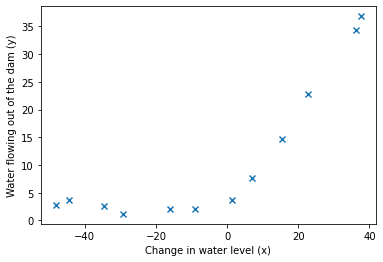

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 1], y, marker='x')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
plt.show()

# 1.2 Regularized linear regression cost function
# 1.3 Regularized linear regression gradient

In [3]:
def hypothesis(theta, z):
    return z @ theta

def cost_function(theta, X, y):
    return 0.5 * ((hypothesis(theta, X) - y) ** 2).mean()

def cost_function_reg(theta, X, y, lam):
    m = len(y)
    return cost_function(theta, X, y) + lam / 2 / m * (theta[1:] ** 2).sum()

def gradient(theta, X, y):
    m = len(y)
    return 1 / m * X.T @ (hypothesis(theta, X) - y)

def gradient_reg(theta, X, y, lam):
    m = len(y)
    grad = 1 / m * X.T @ (hypothesis(theta, X) - y)
    grad[1:] += lam / m * theta[1:]
    return grad

cost_function_reg(np.ones(2), X, y, 1), gradient_reg(np.ones(2), X, y, 1)

(303.9931922202643, array([-15.30301567, 598.25074417]))

# 1.4 Fitting linear regression

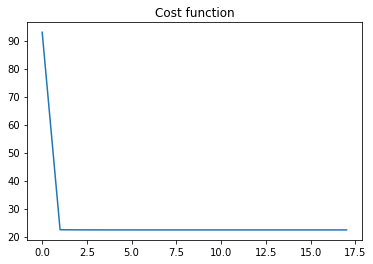

In [4]:
from scipy.optimize import fmin_cg

def train_linear_reg(theta, X, y, lam, plotting=False):
    """Wouldn't change theta passed in."""
    if plotting:
        costs = []
        def cb(tha):
            costs.append(cost_function_reg(tha, X, y, lam))
        result = fmin_cg(cost_function_reg, theta, gradient_reg, (X, y, lam), callback=cb, disp=0)
        plt.plot(costs)
        plt.title('Cost function')
        plt.show()
    else:
        result = fmin_cg(cost_function_reg, theta, gradient_reg, (X, y, lam), disp=0)
    return result

theta_opt = train_linear_reg(np.ones(2), X, y, lam=0, plotting=True)

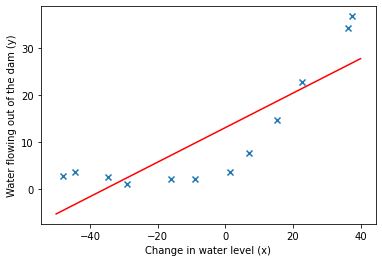

In [5]:
plt.scatter(X[:, 1], y, marker='x')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')

xx = np.linspace(-50, 40, 5).reshape((5, 1))
XX = np.concatenate((np.ones(xx.shape), xx), axis=1)
yy = hypothesis(theta_opt, XX)
plt.plot(XX[:, 1], yy, 'r')

plt.show()

# 2 Bias-variance

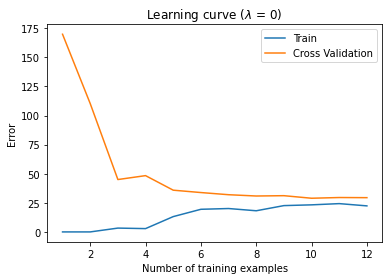

In [6]:
def learning_curve(theta, X, y, Xval, yval, lam):
    error_train = []
    error_val = []
    for n in range(1, len(y) + 1):
        theta_opt = train_linear_reg(theta, X[:n], y[:n], lam)
        error_train.append(cost_function(theta_opt, X[:n], y[:n]))
        error_val.append(cost_function(theta_opt, Xval, yval))
    plt.plot(range(1, len(y) + 1), error_train, label='Train')
    plt.plot(range(1, len(y) + 1), error_val, label='Cross Validation')
    plt.title('Learning curve ($\lambda$ = {})'.format(lam))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend()

learning_curve(np.ones(2), X, y, Xval, yval, 0)

# 3 Polynomial regression

In [7]:
from functools import reduce

DEGREE = 8

def poly_feature(x, degree):
    x = x[:, None]
    return reduce(lambda r, p: np.concatenate((r, x ** p), axis=1), range(1, degree + 1), np.ones(x.shape))

MU = poly_feature(X[:, 1], DEGREE)[:, 1:].mean(axis=0)
SIGMA = poly_feature(X[:, 1], DEGREE)[:, 1:].std(axis=0)

def feature_normalize(X):
    return np.concatenate((np.ones((X.shape[0], 1)), (X[:, 1:] - MU) / SIGMA), axis=1)

feature_normalize(poly_feature(X[:, 1], DEGREE)).shape

(12, 9)

In [8]:
X_norm = feature_normalize(poly_feature(X[:, 1], DEGREE))
Xval_norm = feature_normalize(poly_feature(Xval[:, 1], DEGREE))
Xtest_norm = feature_normalize(poly_feature(Xtest[:, 1], DEGREE))
X_norm.shape, Xval_norm.shape, Xtest_norm.shape

((12, 9), (21, 9), (21, 9))

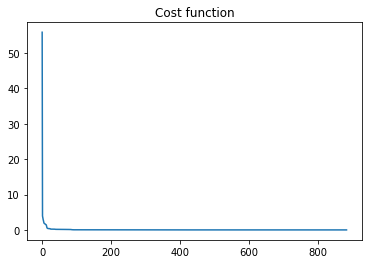

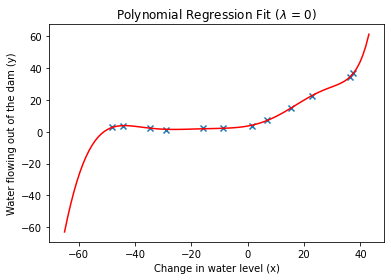

In [9]:
def plot_fitting(lam):
    theta_opt = train_linear_reg(np.ones(DEGREE + 1), X_norm, y, lam, plotting=True)
    xx = np.linspace(-65, 43, 100)
    XX = feature_normalize(poly_feature(xx, DEGREE))
    yy = hypothesis(theta_opt, XX)
    plt.plot(xx, yy, 'r')

    plt.scatter(X[:, 1], y, marker='x')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.title('Polynomial Regression Fit ($\lambda$ = {})'.format(lam))

    plt.show()

plot_fitting(0)

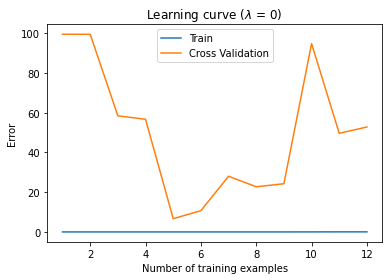

In [10]:
learning_curve(np.ones(DEGREE + 1), X_norm, y, Xval_norm, yval, 0)

# 3.2 Optional (ungraded) exercise: Adjusting the regularization parameter

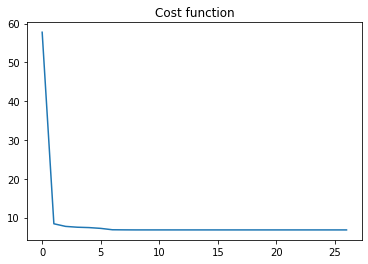

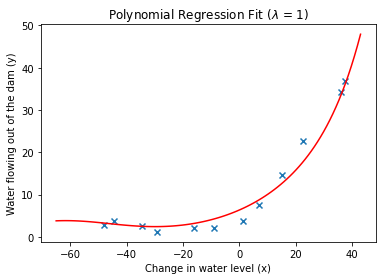

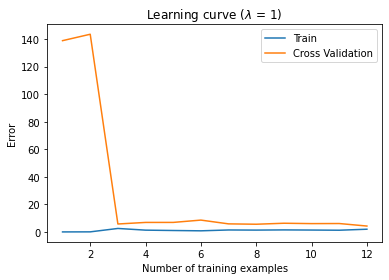

In [11]:
LAM = 1
plot_fitting(LAM)
learning_curve(np.ones(DEGREE + 1), X_norm, y, Xval_norm, yval, lam=LAM)

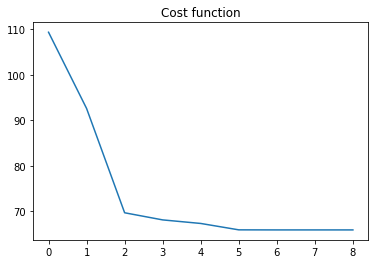

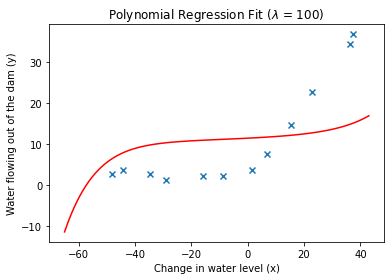

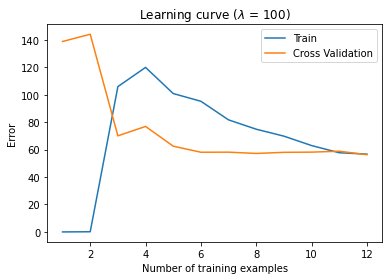

In [12]:
LAM = 100
plot_fitting(LAM)
learning_curve(np.ones(DEGREE + 1), X_norm, y, Xval_norm, yval, lam=LAM)

# 3.3 Selecting λ using a cross validation set

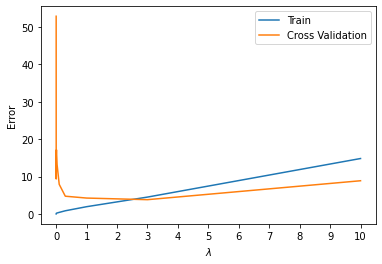

In [13]:
error_train_lam = []
error_val_lam = []

lams = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
for lam in lams:
    theta_opt = train_linear_reg(np.ones(DEGREE + 1), X_norm, y, lam, plotting=False)
    error_train_lam.append(cost_function(theta_opt, X_norm, y))
    error_val_lam.append(cost_function(theta_opt, Xval_norm, yval))

plt.plot(lams, error_train_lam, label='Train')
plt.plot(lams, error_val_lam, label='Cross Validation')
plt.xlabel('$\lambda$')
plt.xticks(range(11))
plt.ylabel('Error')
plt.legend()
plt.show()

$\lambda$ should be around 3.



# 3.4 Optional (ungraded) exercise: Computing test set error

In [14]:
theta_opt = train_linear_reg(np.ones(DEGREE + 1), X_norm, y, 3, plotting=False)
cost_function(theta_opt, Xtest_norm, ytest)

3.5720432231423587

# 3.5 Optional (ungraded) exercise: Plotting learning curves with randomly selected examples

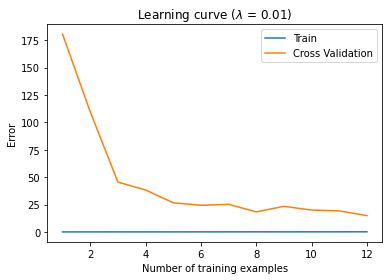

In [15]:
def learning_curve_random(theta, X, y, Xval, yval, lam):
    error_train = []
    error_val = []
    for n in range(1, len(y) + 1):
        error_train_inner = []
        error_val_inner = []
        for _ in range(50):
            spam1 = np.random.randint(0, len(y), size=n)
            theta_opt = train_linear_reg(theta, X[spam1], y[spam1], lam)
            error_train_inner.append(cost_function(theta_opt, X[spam1], y[spam1]))
            spam2 = np.random.randint(0, len(yval), size=n)
            error_val_inner.append(cost_function(theta_opt, Xval[spam2], yval[spam2]))
        error_train.append(error_train_inner)
        error_val.append(error_val_inner)
    error_train = np.array(error_train).mean(axis=1)
    error_val = np.array(error_val).mean(axis=1)

    plt.plot(range(1, len(y) + 1), error_train, label='Train')
    plt.plot(range(1, len(y) + 1), error_val, label='Cross Validation')
    plt.title('Learning curve ($\lambda$ = {})'.format(lam))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend()

learning_curve_random(np.ones(DEGREE + 1), X_norm, y, Xval_norm, yval, lam=0.01)